# **PROJECT: Tuberculosis**

# **AUTHOR: DHARVISH RD**

# **ORGANISATION: PANIMALAR ENGINEERING COLLEGE**

**DATASET PREPARATION**

In [7]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [8]:
#Download your api kaggle.json from kaggle and upload it here
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dharvishrd","key":"a43fc17c7f79e63c012696aefc0b5439"}'}

In [9]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d raddar/tuberculosis-chest-xrays-shenzhen

 99% 3.49G/3.51G [01:33<00:00, 64.9MB/s]
100% 3.51G/3.51G [01:33<00:00, 40.4MB/s]


In [11]:
#unziping the file
from zipfile import ZipFile
file_name = '/content/tuberculosis-chest-xrays-shenzhen.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [12]:
! pip install split-folders


**IMPORT LIBRARIES**

In [13]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import splitfolders 
from glob import glob

**READ DATA**

In [14]:
datainfo = pd.read_csv('/content/shenzhen_metadata.csv')

In [15]:
datainfo.head()

,study_id,sex,age,findings
0,CHNCXR_0001_0.png,Male,45,normal
1,CHNCXR_0002_0.png,Male,63,normal
2,CHNCXR_0003_0.png,Female,48,normal
3,CHNCXR_0004_0.png,Male,58,normal
4,CHNCXR_0005_0.png,Male,28,normal


In [16]:
normal = []
positive =  []

In [17]:
def extract_target(x):
  for i in range(len(x['study_id'])):
    if x['findings'][i] == 'normal':
      normal.append(x['study_id'][i])
    else:
      positive.append(x['study_id'][i])

In [18]:
extract_target(datainfo)


**NORMAL IMAGES IN DATASET**

In [19]:
len(normal)


326

**POSITIVE IMAGES IN DATASET**

In [20]:
len(positive)


336

**Creating Directories**

In [21]:
!mkdir data

In [22]:
!mkdir data/normal
!mkdir data/positive

In [23]:
for i in range(len(normal)):
  path = '/content/images/images/' + normal[i]
  !mv $path /content/data/normal


In [24]:
for i in range(len(positive)):
  path = '/content/images/images/' + positive[i]
  !mv $path /content/data/positive

In [25]:

input_folder = "/content/data"
output = "/content/dataset" #where you want the split datasets saved. one will be created if none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .0, 0.2)) 

Copying files: 662 files [00:17, 38.22 files/s]


**Data Visualization**

In [26]:
tuberculosis  = glob('/content/dataset/test/positive/*.png')
normal = glob('/content/dataset/test/normal/*.png')

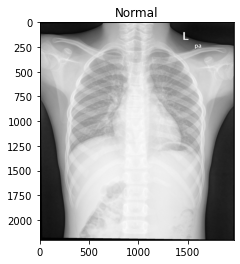

In [27]:
plt.title('Normal')
plt.imshow(image.load_img(np.random.choice(normal)))
plt.show()

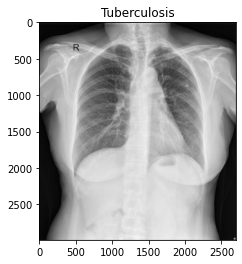

In [28]:

plt.title('Tuberculosis')
plt.imshow(image.load_img(np.random.choice(tuberculosis)))
plt.show()

**Image Processing and Data Partition into Train and Test**

In [30]:
img_width = 150
img_height = 150

datagen = ImageDataGenerator(rescale=1/255.0)

In [31]:
train_data_gen = datagen.flow_from_directory(directory='/content/dataset/train',
                                             target_size = (img_width, img_height),
                                             class_mode = 'sparse')
test_data_gen = datagen.flow_from_directory(directory='/content/dataset/test',
                                            target_size = (img_width, img_height),
                                             class_mode = 'sparse',)

Found 528 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


In [32]:
model = Sequential()

#convolution 
model.add(Conv2D(32, (3,3), input_shape = (img_width, img_height, 3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

#Dense 
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(228, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(270, activation='relu'))
model.add(Dropout(0.3))



model.add(Dense(1, activation='sigmoid'))

In [33]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])


**TRAIN MODEL**

In [34]:
r = model.fit_generator(generator=train_data_gen, 
                              steps_per_epoch=len(train_data_gen),
                              epochs=20, 
                              validation_data= test_data_gen, 
                              validation_steps = len(test_data_gen))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
17/17 [==============================] - 104s 6s/step - loss: 0.7048 - accuracy: 0.4489 - val_loss: 0.6932 - val_accuracy: 0.4925
Epoch 2/20
17/17 [==============================] - 99s 6s/step - loss: 0.6901 - accuracy: 0.5417 - val_loss: 0.6981 - val_accuracy: 0.5075
Epoch 3/20
17/17 [==============================] - 93s 5s/step - loss: 0.6980 - accuracy: 0.4602 - val_loss: 0.6904 - val_accuracy: 0.6642
Epoch 4/20
17/17 [==============================] - 93s 5s/step - loss: 0.6335 - accuracy: 0.6477 - val_loss: 0.5487 - val_accuracy: 0.7910
Epoch 5/20
17/17 [==============================] - 100s 6s/step - loss: 0.5286 - accuracy: 0.7898 - val_loss: 0.4989 - val_accuracy: 0.7910
Epoch 6/20
17/17 [==============================] - 102s 6s/step - loss: 0.4867 - accuracy: 0.7917 - val_loss: 0.4577 - val_accuracy: 0.8209
Epoch 7/20
17/17 [==============================] - 97s 6s/step - loss: 0.4525 - accuracy: 0.8144 - val_loss: 0.4847 - val_accuracy: 0.7910
Epoch 8/20
17/17 


**Analysis**

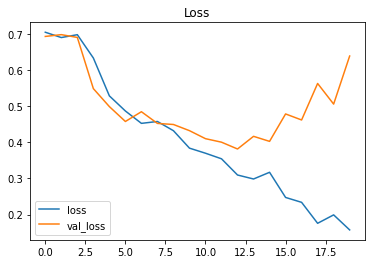

In [35]:
plt.title('Loss')
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

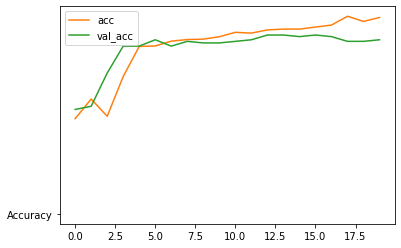

In [36]:
plt.plot('Accuracy')
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [37]:
model.save('Tuberculosis.h5')

In [38]:
model = tf.keras.models.load_model("Tuberculosis.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('Tuberculosis.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpy8yiqoun/assets


9592592